# integration of macaque dataset  with scDML

In [5]:
import scanpy as sc

# 文件路径
file_path = "/Users/jacksonzhang/Desktop/program/scDML-zzw/1.h5ad"

# 加载数据
print("正在加载数据...")
adata = sc.read_h5ad(file_path)

# 查看 adata.obs 的列名
print("\nadata.obs 列名:")
print(adata.obs.columns)

# 查看 'assay' 列数据
if 'assay' in adata.obs.columns:
    print("\n'assay' 列数据:")
    print(adata.obs['assay'].head())  # 显示前几行数据
    print("\n'assay' 列的频次统计:")
    print(adata.obs['assay'].value_counts())  # 统计每种 assay 的数量
else:
    print("\n'assay' 列不存在，请检查列名是否正确。")

# 查看 'cell_type' 列数据
if 'cell_type' in adata.obs.columns:
    print("\n'cell_type' 列数据:")
    print(adata.obs['cell_type'].head())  # 显示前几行数据
    print("\n'cell_type' 列的频次统计:")
    print(adata.obs['cell_type'].value_counts())  # 统计每种 cell_type 的数量
else:
    print("\n'cell_type' 列不存在，请检查列名是否正确。")

正在加载数据...

adata.obs 列名:
Index(['mapped_reference_annotation', 'donor_id', 'donor_age',
       'self_reported_ethnicity_ontology_term_id',
       'donor_living_at_sample_collection', 'organism_ontology_term_id',
       'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id',
       'development_stage_ontology_term_id', 'sample_derivation_process',
       'sample_source', 'tissue_type', 'suspension_depletion_factors',
       'suspension_depleted_cell_types', 'suspension_derivation_process',
       'suspension_dissociation_reagent', 'suspension_dissociation_time',
       'suspension_enriched_cell_types', 'suspension_enrichment_factors',
       'suspension_uuid', 'suspension_type', 'library_uuid',
       'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data',
       'cell_type_ontology_term_id', 'author_cell_type', 'cell_state',
       'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id',
       'sample', 'enrichment', 'age_group', 'study', 'p

## load dataset 

In [6]:
import scDML
print(scDML.__version__)
import scanpy as sc 
import torch
from scDML import scDMLModel
from scDML.utils import print_dataset_information
import matplotlib.pyplot as plt
import os

# 清空终端
os.system("clear")

# 文件路径和聚类数量
ncluster = 3
file_path = "/Users/jacksonzhang/Desktop/program/scDML-zzw/1.h5ad"

# 加载数据
print("加载数据...")
adata_raw = sc.read(file_path)
print("原始数据:")
print(adata_raw)

# 检查 adata.obs 的列名
print("\nadata.obs 的列名:")
print(adata_raw.obs.columns)

# 添加批次信息（如果需要）
if "BATCH" not in adata_raw.obs.columns:
    adata_raw.obs['BATCH'] = adata_raw.obs['assay']  # 使用 'assay' 列作为批次信息

# 移除批次 `10x 3' v3` 的数据
print("移除批次 `10x 3' v3` 的数据...")
adata_raw = adata_raw[adata_raw.obs['BATCH'] != "10x 3' v3"]
print(f"数据移除后形状: {adata_raw.shape}")

# 保存原始数据
adata_raw.raw = adata_raw

# 打印数据集信息
print_dataset_information(adata_raw, batch_key="BATCH", celltype_key="cell_type")

0.0.1
加载数据...
原始数据:
AnnData object with n_obs × n_vars = 2923 × 36406
    obs: 'mapped_reference_annotation', 'donor_id', 'donor_age', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'tissue_type', 'suspension_depletion_factors', 'suspension_depleted_cell_types', 'suspension_derivation_process', 'suspension_dissociation_reagent', 'suspension_dissociation_time', 'suspension_enriched_cell_types', 'suspension_enrichment_factors', 'suspension_uuid', 'suspension_type', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'disease_ontology_term_id', 'reported_diseases', 'sex_ontology_term_id', 'sample', 'enrichment', 'age_group', 'study', 'park_2020_cell_type', 'panfetal_2022_cell_typ

cell_type,macrophage,plasmacytoid dendritic cell,conventional dendritic cell,Total
BATCH,,,,
10x 3' v2,115,209,611,935
10x 5' v2,90,96,628,814
10x 5' v1,346,117,705,1168
Total,551,422,1944,2917


# raw dataset visulization

[<Axes: title={'center': 'assay'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>]

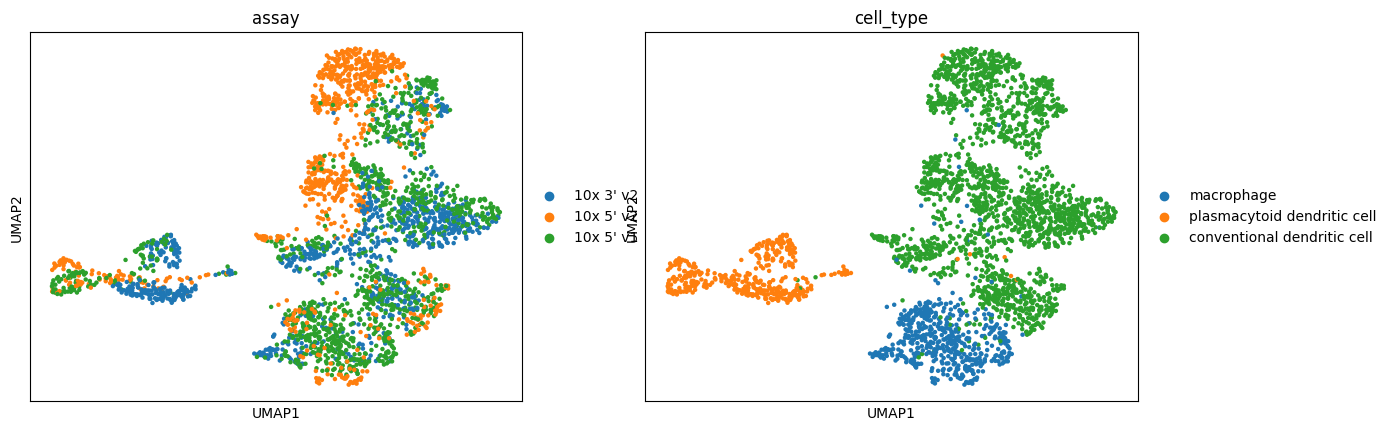

In [14]:
import scanpy as sc
import numpy as np
from scipy.sparse import issparse

# 如果 X 是稀疏矩阵，将其转换为密集矩阵
if issparse(adata_raw.X):
    adata_raw.X = adata_raw.X.toarray()

# 检查并处理 NaN 值
if np.any(np.isnan(adata_raw.X)):
    adata_raw.X = np.nan_to_num(adata_raw.X)

# 检查并处理重复基因
adata_raw.var_names_make_unique()

# 数据预处理
adata_copy = adata_raw.copy()
sc.pp.normalize_total(adata_copy, target_sum=1e4)
sc.pp.log1p(adata_copy)

# 标记高度可变基因
sc.pp.highly_variable_genes(adata_copy, n_top_genes=2000, subset=True, n_bins=20)

# 标准化和 PCA
sc.pp.scale(adata_copy)
sc.tl.pca(adata_copy)

# 邻近图和 UMAP
sc.pp.neighbors(adata_copy)
sc.tl.umap(adata_copy)

# 可视化
sc.pl.umap(adata_copy, color=["assay", "cell_type"], show=False)

# scDML integration

2025-01-16 14:35:17,236 - root - INFO - Create log file....
2025-01-16 14:35:17,236 - root - INFO - Create scDMLModel Object Done....
2025-01-16 14:35:17,238 - root - INFO - Running preprocess() function...
2025-01-16 14:35:17,238 - root - INFO - mode=unsupervised
2025-01-16 14:35:17,238 - root - INFO - clustering method=louvain
2025-01-16 14:35:17,239 - root - INFO - resolution=3.0
2025-01-16 14:35:17,239 - root - INFO - BATCH_key=BATCH
2025-01-16 14:35:17,239 - root - INFO - Normalize counts per cell(sum=10000.0)
2025-01-16 14:35:17,290 - root - INFO - Log1p data
2025-01-16 14:35:17,504 - root - INFO - Select HVG(n_top_genes=1000)
2025-01-16 14:35:17,912 - root - INFO - Scale batch(scale_value=10.0)
2025-01-16 14:35:18,019 - root - INFO - Calculate PCA(n_comps=100)
2025-01-16 14:35:18,548 - root - INFO - Apply louvain clustring(resolution=3.0) initization
2025-01-16 14:35:18,555 - root - INFO - Number of Cluster =27
2025-01-16 14:35:18,564 - root - INFO - clusters=[0, 1, 2, 3, 4, 5, 

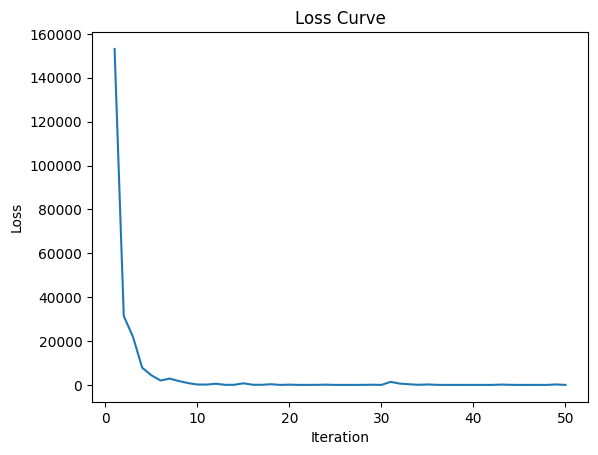

In [15]:
# 定义数据集名称
dataset = "1"  # 请根据实际数据集修改名称

# 设置结果保存目录
save_dir = "./test_result/" + dataset + "/"

# 初始化模型
scdml = scDMLModel(save_dir=save_dir)

# 数据预处理
adata = scdml.preprocess(adata_raw, cluster_method="louvain", resolution=3.0)

# 移除 `10x 3' v3` 批次的数据，因为数据量太小了，会报错，报错内容是 RuntimeError: Cannot return the results in a contiguous 2D array. Probably ef or M is too small
adata = adata[adata.obs['BATCH'] != "10x 3' v3"]

# 数据整合
scdml.integrate(
    adata,
    batch_key="BATCH",
    ncluster_list=[ncluster],
    expect_num_cluster=ncluster,
    merge_rule="rule2"
)

# 绘制损失曲线
plt.plot(range(1, len(scdml.loss) + 1), scdml.loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

# visulization of integrated embedding

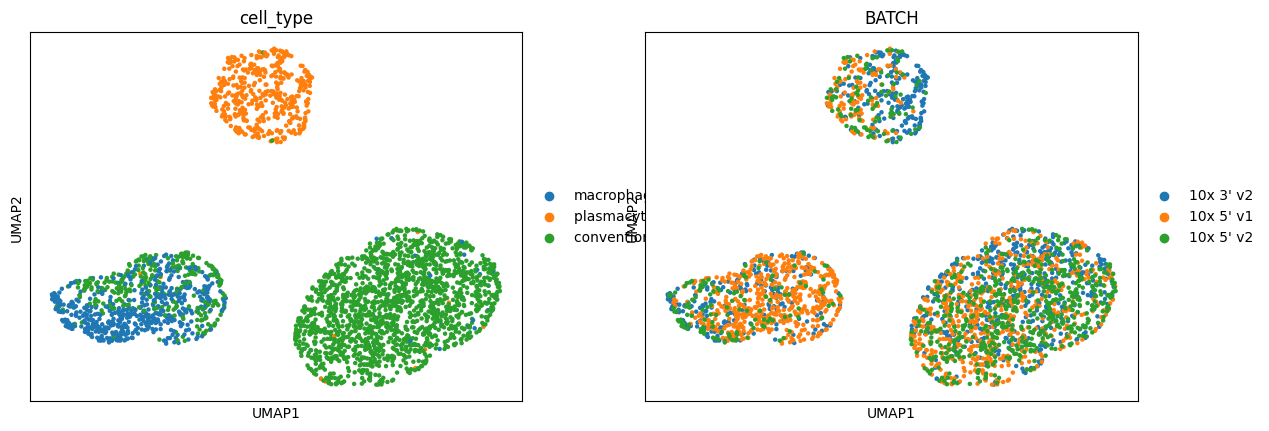

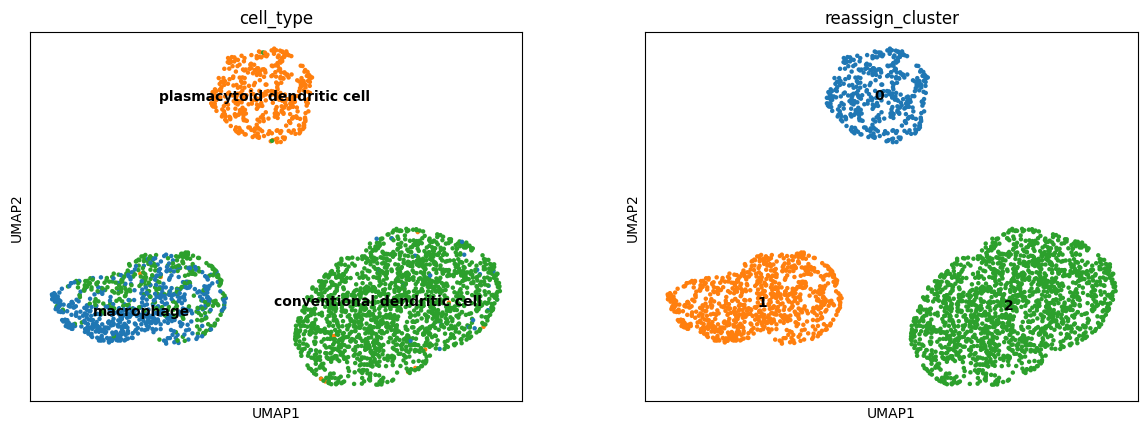

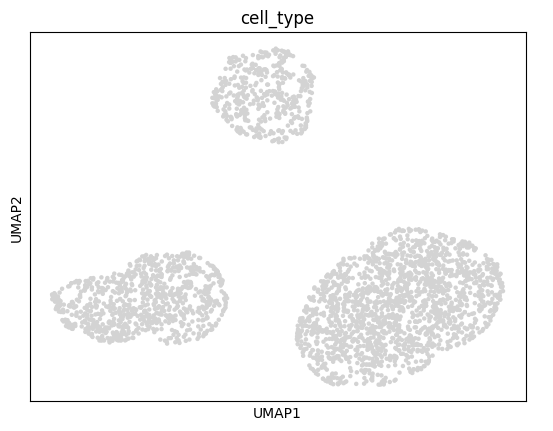

In [16]:
###########################################
# 计算邻居并运行 UMAP
sc.pp.neighbors(adata, random_state=0, use_rep="X_emb")
sc.tl.umap(adata)
###########################################

# 绘制 UMAP 按照细胞类型和批次
sc.pl.umap(adata, color=["cell_type", "BATCH"], show=False)

# 绘制 UMAP 包含重新分配的聚类结果
sc.pl.umap(adata, color=["cell_type", "reassign_cluster"], legend_loc="on data", show=False)

# 绘制特定细胞类型分组，例如 OFFx
sc.pl.umap(adata, color=["cell_type"], groups=["OFFx"], na_in_legend=False)

# evaluation

In [17]:
import pandas as pd
df=pd.crosstab(adata.obs["cell_type"],adata.obs["reassign_cluster"])
col=df.apply('idxmax', axis=1).values
df=df[col]
df

reassign_cluster,1,0,2
cell_type,,,
macrophage,529,0,22
plasmacytoid dendritic cell,2,410,10
conventional dendritic cell,303,2,1639


In [18]:
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
ari=adjusted_rand_score(adata.obs["reassign_cluster"],adata.obs["cell_type"])
nmi=normalized_mutual_info_score(adata.obs["reassign_cluster"],adata.obs["cell_type"])
print("ARI={}".format(ari))
print("NMI={}".format(nmi))

ARI=0.6555837028388245
NMI=0.668305940775144


# citation

Peng, Y.-R. et al. Molecular Classification and Comparative Taxonomics of Foveal and Peripheral Cells in Primate Retina. Cell 176, 1222-1237.e22 (2019).

In [8]:
# Attention!!!!
# you can also use leiden clustering algorithm to for cluster inizitization, 
# It may give more accurate result than louvain